## TO DO: 
#### Understand what is the source of the perfect training accuracy: 
* Logistic Regression: play on the C parameter
* RF: play on the parameters that can reduce overfitting
#### Features highly correlated with NHY feature:
* NP3FACXP, NP3FTAPR, NP3HMOVR, NP3PRSPR, NP3TTAPR,NP3POSTR, NP3BRADY,NP2TMPR,NP3SPCH,MSEADLG

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# I. Features importance & Non TS classification of Disease Progression

## 1. Data preparation

In [3]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
df.head()

,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


In [6]:
UPDRS_feat=['NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT', 'NP1DDS', 'NP2SPCH', 'NP2SALV', 
            'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 
            'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 
            'PN3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 
            'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 
            'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 
            'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES','NP4WDYSK',
            'NP4DYSKI', 'NP4OFF', 'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN']
df.drop(columns=UPDRS_feat,inplace=True)

In [7]:
dfAgg=df.groupby('PATNO').agg('median')
dfAgg.drop(columns=['visitsdiff_days','VISIT_ID'],inplace=True)
dfAgg.drop(columns='MSEADLG',inplace=True)
dfAgg['NHY']=dfAgg['NHY'].apply(lambda x: round(x,0))
dfAgg.head()

,ON_OFF_DOSE,PD_MED_USE,NHY,PDMEDYN,ONLDOPA,ONDOPAG,ONOTHER,FULNUPDR,PDSURG,PDSURGTP,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,1.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,...,1.0,1.0,0.0,0.0,2.0,7.0,1552.0,1461.0,0.0,0.0
3002,1.5,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,0.0,1.0,1.0,6.0,1567.5,1504.5,0.0,0.0
3003,0.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,...,1.0,1.0,1.0,1.0,2.0,7.0,1552.0,1857.0,0.0,0.0
3006,0.5,3.0,2.0,0.5,0.0,0.5,0.5,0.5,0.0,4.0,...,1.0,1.0,0.0,0.0,2.0,2.0,2465.5,333.5,0.0,0.0
3007,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,0.0,1.0,2.0,1.0,2648.0,90.0,0.0,0.0


In [8]:
dfAgg['NHY'].value_counts()

2.0    692
0.0    683
1.0    203
3.0     69
4.0     24
5.0      3
Name: NHY, dtype: int64

## 2. Split train, test

In [9]:
from sklearn.model_selection import train_test_split
data=dfAgg.drop(columns='NHY')
target=dfAgg['NHY']
train, test = train_test_split(dfAgg, test_size=0.3, random_state=0)
train.to_pickle("./train_nonTS.pickle")
test.to_pickle("./test_nonTS.pickle")
print('train counts: {}'.format(train.NHY.value_counts()))
X_train = train.loc[:,train.columns!='NHY']
y_train = train['NHY']
X_test = test.loc[:,train.columns!='NHY']
y_test = test[('NHY')]
print(X_train.shape)
print('test counts: {}'.format(y_test.value_counts()))
train.head()

train counts: 0.0    478
2.0    475
1.0    147
3.0     51
4.0     18
5.0      2
Name: NHY, dtype: int64
(1171, 311)
test counts: 2.0    217
0.0    205
1.0     56
3.0     18
4.0      6
5.0      1
Name: NHY, dtype: int64


,ON_OFF_DOSE,PD_MED_USE,NHY,PDMEDYN,ONLDOPA,ONDOPAG,ONOTHER,FULNUPDR,PDSURG,PDSURGTP,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
12898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1734.0,0.0,0.0,0.0
41544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,2.0,745.5,0.0,0.0,0.0
41284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,4.0,455.0,0.0,0.0,0.0
53015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,791.0,0.0,0.0,0.0
4080,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,0.0,0.0,2.0,1.0,2099.0,30.0,0.0,0.0


### Take care of the classes unbalance

In [10]:
from sklearn.utils import resample

train_majority = train[train.NHY==0.0]
train_minority_1 = train[train.NHY==1.0]
train_minority_2= train[train.NHY==2.0]
train_minority_3= train[train.NHY==3.0]
train_minority_4=train[train.NHY==4.0]
train_minority_5=train[train.NHY==5.0]

# Upsample minority class
train_minority_upsampled_1 = resample(train_minority_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_2 = resample(train_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_3 = resample(train_minority_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_4= resample(train_minority_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_5= resample(train_minority_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled_1,train_minority_upsampled_2,
                             train_minority_upsampled_3,train_minority_upsampled_4,
                             train_minority_upsampled_5])
# Show new class counts
train_upsampled.NHY.value_counts()

5.0    478
4.0    478
3.0    478
2.0    478
1.0    478
0.0    478
Name: NHY, dtype: int64

In [11]:
X_train_up = train_upsampled.loc[:,train.columns!='NHY']
y_train_up= train_upsampled['NHY']

`from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
X_resampled.shape
logreg_smote = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)`

In [17]:
#X_resampled, y_resampled = ADASYN().fit_sample(X, y)
#clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

## 3. Model Training

### Dummy Classifier

In [12]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [19]:
print("Train-Score: %.4f, Test-Accuracy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score: 0.3629, Test-Accuracy: 0.3479


### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
logreg_up=LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=1)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [15]:
rfc_up = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_up.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [16]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### XGBoost

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=-1,seed=0)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

### feature importance
do a pairplot of the important features in the original dataset

In [19]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures=feature_importances[feature_importances.values>=0.01]
print(sum(ImportantFeatures.values))
ImportantFeatures

[0.66894395]


,importance
PDDXDT_diff_days,0.079224
DOMSIDE,0.065820
DXBRADY,0.041230
PRIMDIAG,0.038867
DXTREMOR,0.036411
PD_MED_USE,0.031057
DFRIGIDP,0.029691
DFBRADYP,0.029366
DFRTREMP,0.027075
DFPGDIST,0.023743


In [20]:
feature_importances_up = pd.DataFrame(rfc_up.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_up=feature_importances_up[feature_importances.values>=0.01]
#ImportantFeatures_up

## 4. Evaluation: Calculating, plotting metrics

In [22]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg.score(X_train, y_train), 
                                                                logreg.score(X_test, y_test)))
print("Train-Score-logreg-up: %.4f, Test-Accuracy-logreg-up: %.4f" % (logreg_up.score(X_train_up, y_train_up), 
                                                                      logreg_up.score(X_test, y_test)))
print("Train-Score-rfc-up: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_up.score(X_train_up, y_train_up), 
                                                             rfc_up.score(X_test, y_test)))
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc.score(X_train, y_train), 
                                                          rfc.score(X_test, y_test)))
print("XGB-Train-Accuracy: %.2f%%, XGB-Test-Accuracy: %.2f%%" % (100. * xgb.score(X_train, y_train), 
                                                         100. * xgb.score(X_test, y_test)))

Train-Score-logreg: 0.9334, Test-Accuracy-logreg: 0.7773
Train-Score-logreg-up: 0.9658, Test-Accuracy-logreg-up: 0.6958
Train-Score-rfc-up: 1.0000, Test-Accuracy-rfc: 0.8151
Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.8330
XGB-Train-Accuracy: 93.85%, XGB-Test-Accuracy: 83.10%


### Confusion Matrix

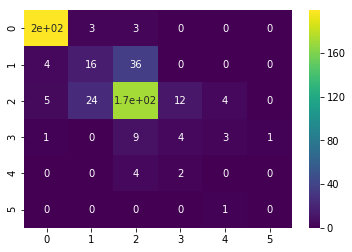

In [23]:
y_pred_logreg=logreg.predict(X_test)
cm_logreg=confusion_matrix(y_test,y_pred_logreg)
cm_logreg_df=pd.DataFrame(cm_logreg,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
import seaborn as sns
sns.heatmap(cm_logreg_df,annot=True,cmap='viridis')

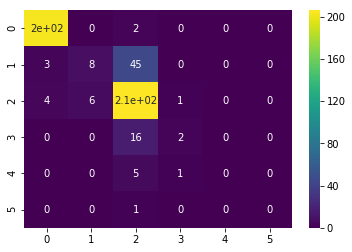

In [24]:
y_pred_rfc=rfc.predict(X_test)
cm_rfc=confusion_matrix(y_test,y_pred_rfc)
cm_rfc_df=pd.DataFrame(cm_rfc,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
sns.heatmap(cm_rfc_df,annot=True,cmap='viridis')

### classification report

In [25]:
from sklearn.metrics import classification_report
report_logreg = classification_report(y_test, 
                      y_pred_logreg)
print(report_logreg)

             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96       205
        1.0       0.37      0.29      0.32        56
        2.0       0.77      0.79      0.78       217
        3.0       0.22      0.22      0.22        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.77      0.78      0.77       503



In [26]:
report_rfc = classification_report(y_test, 
                      y_pred_rfc)
print(report_rfc)

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       205
        1.0       0.57      0.14      0.23        56
        2.0       0.75      0.95      0.84       217
        3.0       0.50      0.11      0.18        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.80      0.83      0.79       503



In [27]:
y_pred_rfc_up=rfc_up.predict(X_test)
report_rfc_up = classification_report(y_test, 
                      y_pred_rfc_up)
print(report_rfc_up)

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.97       205
        1.0       0.49      0.32      0.39        56
        2.0       0.77      0.86      0.81       217
        3.0       0.18      0.11      0.14        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.78      0.82      0.80       503



In [28]:
y_pred_xgb=xgb.predict(X_test)
report_xgb = classification_report(y_test, 
                      y_pred_xgb)
print(report_xgb)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99       205
        1.0       0.44      0.20      0.27        56
        2.0       0.77      0.93      0.84       217
        3.0       0.50      0.17      0.25        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.80      0.83      0.80       503



## 5. Cross-Validation

In [32]:
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score
#cv_score=cross_val_score(logreg,data,target,cv=5,n_jobs=-1)
#print(cv_score)

# C = 1/lambda, the parameter of the sigmoid function
# lambda = 0.001, 0.005, 0.01, 0.05, ..., 1, 5, 10, 50

In [33]:
#print(cv_score.mean())

In [34]:
cv_score_rfc=cross_val_score(rfc,data,target,cv=5,n_jobs=-1)
print(cv_score_rfc)
print(cv_score_rfc.mean())

[0.82492582 0.8694362  0.85416667 0.82582583 0.83987915]
0.8428467328750393


## 6. Hyperparameter tuning with GridSearchCV

In [36]:
#param_grid_rfc={'n_estimators':[5,10,15,20],
               #'max_features':[5,10,15,20,50,100],
               #'max_depth':[None,5,15,25,50],
               #'max_leaf_nodes':[None,25,50,100,200],
               #'min_samples_leaf':[1,5,10,15,20]}
param_grid_rfc={'n_estimators':[10,15,20],
               'max_features':[10,50,100],
               'max_leaf_nodes':[None,25,50,100]}
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid_rfc,cv=5)

In [37]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': [10, 50, 100], 'max_leaf_nodes': [None, 25, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best parameters: {'max_features': 100, 'max_leaf_nodes': None, 'n_estimators': 15}
Best cross-validation score: 0.85


# II. Time-series prediction (input timestep=3)

In [29]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

#file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
#df2=pd.read_csv(file_path)
#print(df2.shape)
df_th2=patients_selection(df,threshold=2)[1]
print(df_th2.shape)
df_th2['num_visits'].value_counts()

(4113, 317)


6    852
7    714
2    586
3    564
5    525
4    512
8    360
Name: num_visits, dtype: int64

### padding for patients with visits <4

In [30]:
rowstoAdd=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd['VISIT_ID']=3
rowstoAdd['visitsdiff_days']=3*61
rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                 rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
maskMED=rowstoAdd['PDMEDT_diff_days']!=0
rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']

rowstoAdd2=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd2['VISIT_ID']=4
rowstoAdd2['visitsdiff_days']=3*61
rowstoAdd2['lastDate_diff_days']=rowstoAdd2['lastDate_diff_days']-rowstoAdd2['visitsdiff_days']
rowstoAdd2['PDDXDT_diff_days']=rowstoAdd2['PDDXDT_diff_days'].where(rowstoAdd2['PDDXDT_diff_days']==0,
                                                                 rowstoAdd2['PDDXDT_diff_days']+rowstoAdd2['visitsdiff_days'])

rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd2.loc[maskMED,'visitsdiff_days']
rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd2.loc[maskSURG,'visitsdiff_days']


rows3toAdd=df_th2[df_th2['num_visits']==3].groupby('PATNO').median()
rows3toAdd['VISIT_ID']=4
rows3toAdd['visitsdiff_days']=3*61
rows3toAdd['lastDate_diff_days']=rows3toAdd['lastDate_diff_days']-rows3toAdd['visitsdiff_days']
rows3toAdd['PDDXDT_diff_days']=rows3toAdd['PDDXDT_diff_days'].where(rows3toAdd['PDDXDT_diff_days']==0,
                                                                 rows3toAdd['PDDXDT_diff_days']+rows3toAdd['visitsdiff_days'])
mask3MED=rows3toAdd['PDMEDT_diff_days']!=0
rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']=rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']+rows3toAdd.loc[mask3MED,'visitsdiff_days']
mask3SURG=rows3toAdd['PDSURGDT_diff_days']!=0
rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']=rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']+rows3toAdd.loc[mask3SURG,'visitsdiff_days']

rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rows3toAdd])
rowspadding['num_visits']=4
rowspadding.reset_index(inplace=True)
print(rowspadding.shape)
dfpad_th4=df_th2.drop(columns='INFODT_date')
print(dfpad_th4.shape)
dfpad_th4=pd.concat([dfpad_th4,rowspadding])
print(dfpad_th4.shape)
dfpad_th4['num_visits'].replace(2,4,inplace=True)
dfpad_th4['num_visits'].replace(3,4,inplace=True)
dfpad_th4.reset_index(drop=True,inplace=True)
dfpad_th4.head()
print((len(rowstoAdd),len(rows3toAdd)))

(774, 316)
(4113, 316)
(4887, 316)
(293, 188)


### cropping for number of visits > 4

In [31]:
dfpad_th4['visits_thresold']=dfpad_th4['VISIT_ID']-(dfpad_th4['num_visits']-4)
print(dfpad_th4.shape)
rowsToDrop=dfpad_th4[(dfpad_th4['num_visits']>4) & (dfpad_th4['visits_thresold']<=0)].index
print(len(rowsToDrop))
dfpaddrop_th4=dfpad_th4.drop(index=list(rowsToDrop),columns='visits_thresold')
dfpaddrop_th4['NHY']=dfpaddrop_th4['NHY'].apply(lambda x: round(x,0))
print(dfpaddrop_th4.shape)
print('number pf patients:{}'.format(len(set(dfpaddrop_th4['PATNO']))))
set(dfpaddrop_th4['NHY'])

(4887, 317)
875
(4012, 316)
number pf patients:1003


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}

### creating data and targets

In [32]:
datatoDrop=dfpaddrop_th4[dfpaddrop_th4['num_visits']==dfpaddrop_th4['VISIT_ID']]
data_TS=dfpaddrop_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG'])
print(data_TS.shape)
data_TS.sort_values(['PATNO','VISIT_ID'],inplace=True)
data_TS.set_index(keys=['PATNO'],inplace=True)
data_TS.head()

(3009, 315)


,ON_OFF_DOSE,PD_MED_USE,NHY,PDMEDYN,ONLDOPA,ONDOPAG,ONOTHER,FULNUPDR,PDSURG,PDSURGTP,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,2.0,6.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,...,0.0,0.0,2.0,7,4,335,1552.0,1461.0,0.0,0.0
3001,1.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,...,0.0,0.0,2.0,7,5,365,1187.0,1826.0,0.0,0.0
3001,1.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,...,0.0,0.0,2.0,7,6,427,760.0,2253.0,0.0,0.0
3002,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,1.0,6,3,365,1917.0,1155.0,0.0,0.0
3002,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,1.0,6,4,699,1218.0,1854.0,0.0,0.0


In [33]:
targettoDrop=dfpaddrop_th4[dfpaddrop_th4['VISIT_ID']==dfpaddrop_th4['num_visits']-3]
len(targettoDrop)
target_TS=dfpaddrop_th4.drop(index=list(datatoDrop.index))
target_TS.sort_values(['PATNO','VISIT_ID'],inplace=True)
target_TS.set_index(keys=['PATNO'],inplace=True)
target_TS=target_TS['NHY']
print(target_TS.shape)
list(set(target_TS.values))

(3009,)


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

## III. Without cropping (time series of different length witn min length=4)

In [34]:
dfpad_th4['NHY']=dfpad_th4['NHY'].apply(lambda x: round(x,0))
dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
print(dfpad_th4.shape)

datatoDrop=dfpad_th4[dfpad_th4['num_visits']==dfpad_th4['VISIT_ID']]
print(datatoDrop.shape)
data_TS=dfpad_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG','visits_thresold'])
data_TS.set_index(keys=['PATNO'],inplace=True)
print(data_TS.shape)
dd=data_TS['NHY']

targettoDrop=dfpad_th4[dfpad_th4['VISIT_ID']==1]
print(targettoDrop.shape)
target_TS=dfpad_th4.drop(index=list(targettoDrop.index))
target_TS.set_index(keys=['PATNO'],inplace=True)
assert len(target_TS)==len(data_TS)
assert set(data_TS.index)==set(target_TS.index)
target_TS=target_TS['NHY']
print(target_TS.shape)
list(set(target_TS.values))

(4887, 317)
(1003, 317)
(3884, 314)
(1003, 317)
(3884,)


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

### Training ML models (Logistic Regression, RandomForest, XGBoost)

#### custom train/test split for time-series data

In [54]:
print(round(0.2*len(set(data_TS.index)),0))
np.random.seed(123)
pat_testset=np.random.choice(list(set(data_TS.index)),201,replace=False)
X_test=data_TS.loc[pat_testset,:]
X_test.head(50)
print(X_test.shape)
X_train=data_TS.drop(index=pat_testset)
print(X_train.shape)
y_test=target_TS[pat_testset]
print(y_test.shape)
assert set(y_test.index)==set(X_test.index)
y_train=target_TS.drop(index=pat_testset)
print(y_train.shape)
assert set(y_train.index)==set(X_train.index)

201.0
(787, 314)
(3097, 314)
(787,)
(3097,)


#### DummyClassifier

In [36]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [37]:
print("Train-Score-dummy: %.4f, Test-Accuracy-dummy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score-dummy: 0.3626, Test-Accuracy-dummy: 0.4057


#### Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
logreg_TS = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg_TS.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

#### Random Forest

In [40]:
rfc_TS = RandomForestClassifier(n_estimators=100, random_state=1,n_jobs=-1)
rfc_TS.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

#### XGBoost

In [47]:
from xgboost import XGBClassifier
xgb_TS = XGBClassifier(n_jobs=-1,seed=0)
xgb_TS.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [48]:
print("Train-Score-logreg: %.2f, Test-Accuracy-logreg: %.2f" % (logreg_TS.score(X_train, y_train), 
                                                                logreg_TS.score(X_test, y_test)))
print("Train-Score-rfc: %.2f, Test-Accuracy-rfc: %.4f" % (rfc_TS.score(X_train, y_train), 
                                                          rfc_TS.score(X_test, y_test)))
print("Train-Score-rfc: %.2f, Test-Accuracy-rfc: %.2f" % (rfc_TS.score(X_train, y_train), 
                                                          rfc_TS.score(X_test, y_test)))
print("Train-Score-xgb: %.2f, Test-Accuracy-xgb: %.2f" % (xgb_TS.score(X_train, y_train), 
                                                          xgb_TS.score(X_test, y_test)))

Train-Score-logreg: 0.87, Test-Accuracy-logreg: 0.78
Train-Score-rfc: 1.00, Test-Accuracy-rfc: 0.7953
Train-Score-rfc: 1.00, Test-Accuracy-rfc: 0.80
Train-Score-xgb: 0.88, Test-Accuracy-xgb: 0.82


### PLotting the results. 

In [50]:
y_pred_logreg=logreg_TS.predict(X_test)
predictions_logreg=pd.Series(y_pred_logreg,index=y_test.index)

y_test_pred_logreg=pd.concat([y_test,predictions_logreg],axis=1)
y_test_pred_logreg.rename(columns={'NHY':'trueLabel',0:'prediction_logreg'},inplace=True)

VISIT_ID=[2]
for i in range(1,len(y_test_pred_logreg)):
    if (y_test_pred_logreg.index[i]==y_test_pred_logreg.index[i-1]):
        visit=VISIT_ID[len(VISIT_ID)-1]+1
    else:
        visit=2
    VISIT_ID.append(visit)
print(len(VISIT_ID))
y_test_pred_logreg['VISIT_ID_future']=VISIT_ID

y_pred_rfc=pd.Series(rfc_TS.predict(X_test),index=y_test.index)
y_pred_rfc.name='prediction_rfc'
y_pred_xgb=pd.Series(xgb_TS.predict(X_test),index=y_test.index)
y_pred_xgb.name='prediction_xgb'

test_all=pd.concat([X_test,y_test_pred_logreg, y_pred_rfc,y_pred_xgb],axis=1)
print(len(test_all))
results_toplot=test_all[['num_visits','VISIT_ID','NHY','VISIT_ID_future','trueLabel','prediction_logreg',
                         'prediction_rfc','prediction_xgb']]
results_toplot.reset_index(inplace=True)
results_toplot.head()

801
801


,PATNO,num_visits,VISIT_ID,NHY,VISIT_ID_future,trueLabel,prediction_logreg,prediction_rfc,prediction_xgb
0,51392,4,1,0.0,2,0.0,0.0,0.0,0.0
1,51392,4,2,0.0,3,0.0,0.0,0.0,0.0
2,51392,4,3,0.0,4,0.0,0.0,0.0,0.0
3,91097,4,1,0.0,2,0.0,0.0,0.0,0.0
4,91097,4,2,0.0,3,0.0,0.0,0.0,0.0


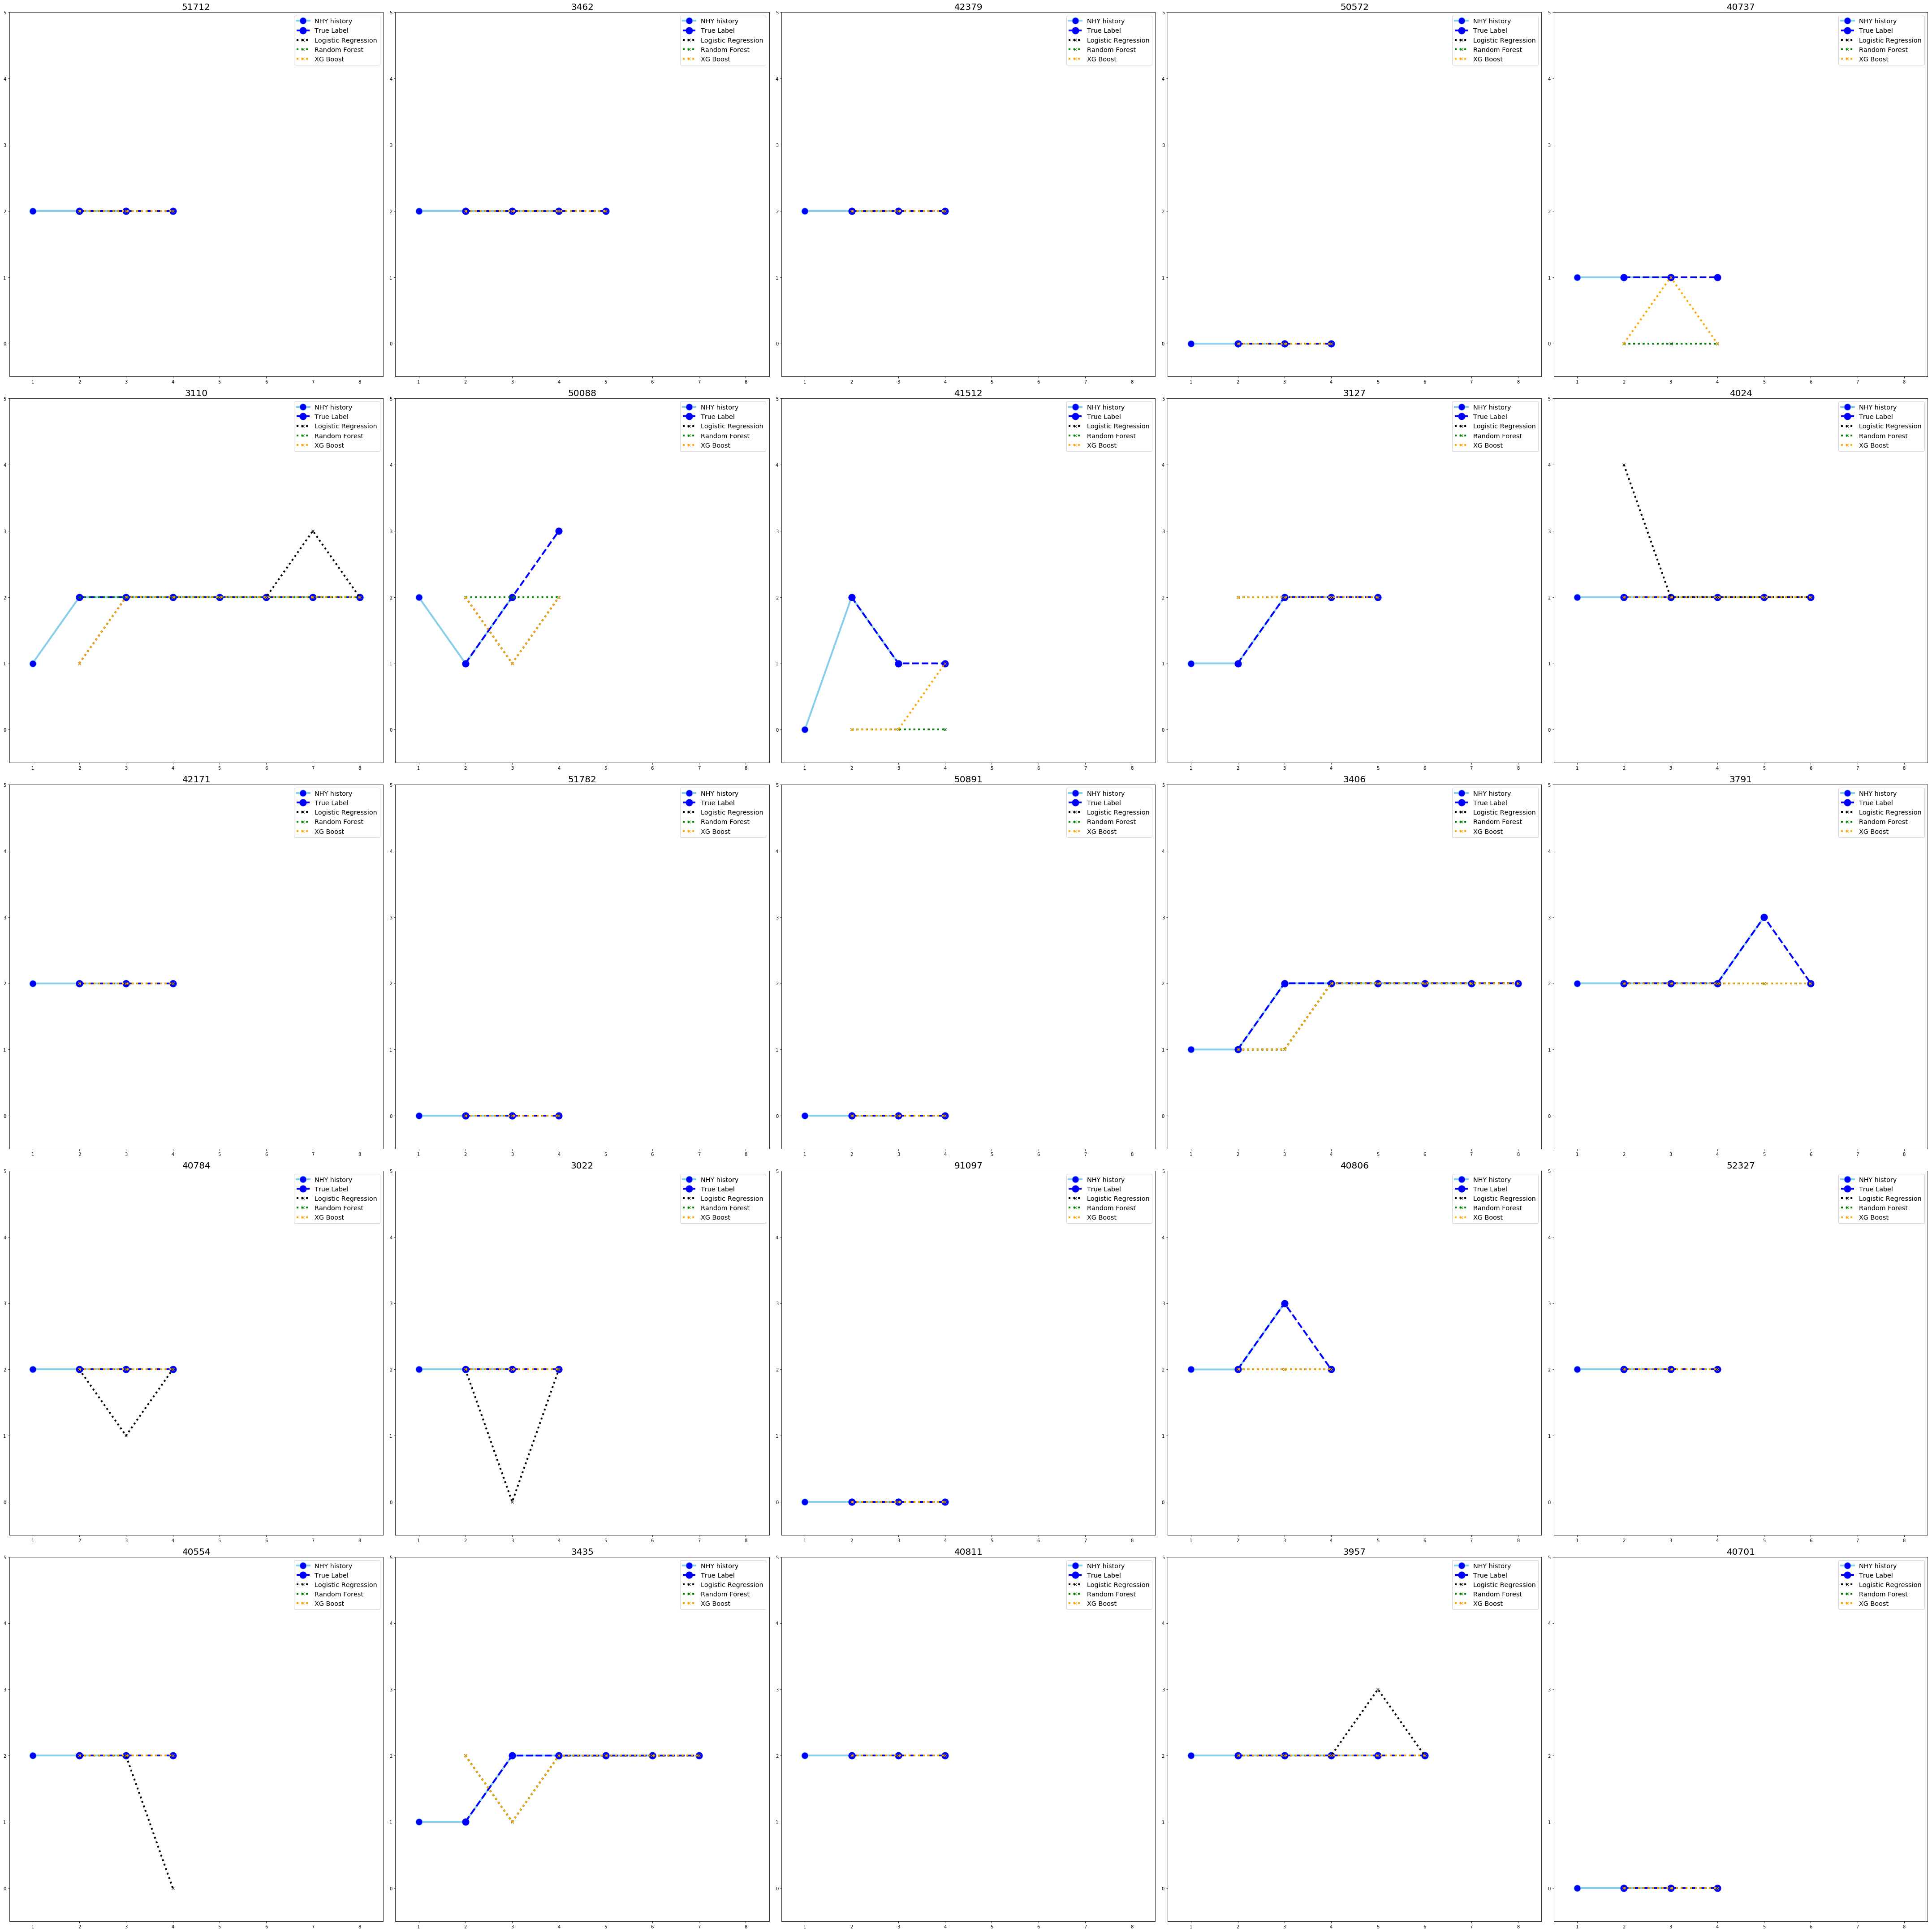

In [51]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,len(set(df['PATNO'])),sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df

def patients_sampling_MoreThanOneVisit(df,sample_size=25,seed=123):
    np.random.seed(seed)
    df=df[df['num_visits']> 1]
    list_pat=list(set(df['PATNO']))
    patients_sample=list(np.random.choice(list_pat,25,replace=False))
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df
df_toPlot=patients_sampling_MoreThanOneVisit(results_toplot)


fig = plt.figure(figsize=(60,60))
num_pat=len(set(df_toPlot['PATNO']))
for pat,num in zip(list(set(df_toPlot['PATNO'])),range(1,num_pat+1)):
    df0=df_toPlot[df_toPlot['PATNO']==pat]
    ax = fig.add_subplot(5,5,num)
    ax.plot(df0['VISIT_ID'], df0['NHY'],marker='o', markerfacecolor='blue', markersize=15, 
            color='skyblue', linewidth=4,label='NHY history')
    ax.plot(df0['VISIT_ID_future'], df0['trueLabel'],marker='o',markersize=15,
            color='blue',linestyle='dashed',linewidth=4,label='True Label')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_logreg'], marker='x', 
            color='black', linewidth=4, linestyle='dotted', label='Logistic Regression')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_rfc'], marker='x', 
            color='green', linewidth=4, linestyle='dotted', label='Random Forest')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_xgb'], marker='x', 
            color='orange', linewidth=4, linestyle='dotted', label='XG Boost')
    ax.set_xlim([0.5, 8.5])
    ax.set_ylim([-0.5, 5])
    ax.set_title(pat,fontdict={'fontsize':20})
    ax.legend(fontsize='x-large')
plt.tight_layout()
#fig.figure.suptitle('true labels vs predictions')
plt.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/predictions_NHY_123_wo_UPDRS.png')
plt.show()       

### Features importance

In [ ]:
feature_importances = pd.DataFrame(rfc_TS.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_TS=feature_importances[feature_importances.values>=0.01]
print(ImportantFeatures.values.sum())
ImportantFeatures_TS
#feature_importances